In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib
%matplotlib inline

In [2]:
conn = sqlite3.connect('../../data/hubs.db')
df_10 = pd.read_sql_query("SELECT * from HIGH_RISK_10", conn)
df_6 = pd.read_sql_query("SELECT * from HIGH_RISK_6", conn)
df_15 = pd.read_sql_query("SELECT * from HIGH_RISK_15", conn)
df_20 = pd.read_sql_query("SELECT * from HIGH_RISK_20", conn)
df_10.head()

report_date HR_UID  cases  cumulative_cases  deaths  cumulative_deaths
0  2020-01-25   1011    1.0               1.0     1.0                1.0
1  2020-01-25   1012    0.0               0.0     0.0                0.0
2  2020-01-25   1013    0.0               0.0     0.0                0.0
3  2020-01-25   1014    0.0               0.0     0.0                0.0
4  2020-01-25   1100    0.0               0.0     0.0                0.0

In [7]:
df_10.rename(columns={"cumulative_cases": "cumulative_cases_10"}, inplace=True)
df_6.rename(columns={"cumulative_cases": "cumulative_cases_6"}, inplace=True)
df_15.rename(columns={"cumulative_cases": "cumulative_cases_15"}, inplace=True)
df_20.rename(columns={"cumulative_cases": "cumulative_cases_20"}, inplace=True)
df_20.head()

report_date HR_UID  cases  cumulative_cases_20  deaths  cumulative_deaths
0  2020-01-25   1011    1.0                  1.0     1.0                1.0
1  2020-01-25   1012    0.0                  0.0     0.0                0.0
2  2020-01-25   1013    0.0                  0.0     0.0                0.0
3  2020-01-25   1014    0.0                  0.0     0.0                0.0
4  2020-01-25   1100    0.0                  0.0     0.0                0.0

In [23]:
df_6['report_date'] = pd.to_datetime(df_6['report_date'])
df_10['report_date'] = pd.to_datetime(df_10['report_date'])
df_15['report_date'] = pd.to_datetime(df_15['report_date'])
df_20['report_date'] = pd.to_datetime(df_20['report_date'])
df_merge = pd.merge(df_6, df_10, on=['report_date', 'HR_UID'])
df_merge1 = pd.merge(df_merge, df_15, on=['report_date', 'HR_UID'])
df_merge2 = pd.merge(df_merge1, df_20, on=['report_date', 'HR_UID'])
df_merge2.head()

report_date HR_UID  cases_x  cumulative_cases_6  deaths_x  \
0  2020-01-25   1011      1.0                 1.0       1.0   
1  2020-01-25   1012      0.0                 0.0       0.0   
2  2020-01-25   1013      0.0                 0.0       0.0   
3  2020-01-25   1014      0.0                 0.0       0.0   
4  2020-01-25   1100      0.0                 0.0       0.0   

   cumulative_deaths_x  cases_y  cumulative_cases_10  deaths_y  \
0                  1.0      1.0                  1.0       1.0   
1                  0.0      0.0                  0.0       0.0   
2                  0.0      0.0                  0.0       0.0   
3                  0.0      0.0                  0.0       0.0   
4                  0.0      0.0                  0.0       0.0   

   cumulative_deaths_y  cases_x  cumulative_cases_15  deaths_x  \
0                  1.0      1.0                  1.0       1.0   
1                  0.0      0.0                  0.0       0.0   
2                  0.0      0.0                  0.0       0.0   
3                  0.0      0.0                  0.0       0.0   
4                  0.0      0.0                  0.0       0.0   

   cumulative_deaths_x  cases_y  cumulative_cases_20  deaths_y  \
0                  1.0      1.0                  1.0       1.0   
1                  0.0      0.0                  0.0       0.0   
2                  0.0      0.0                  0.0       0.0   
3                  0.0      0.0                  0.0       0.0   
4                  0.0      0.0                  0.0       0.0   

   cumulative_deaths_y  
0                  1.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0

In [31]:
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
HR_lst = df_mob.loc[df_mob['PRUID']=='35', 'HR_UID'].unique().tolist()
df_merge3 = df_merge2.loc[(df_merge2['HR_UID'].isin(HR_lst)) & (df_merge2['report_date']>= '2020-07-01')]
df_merge3.head()

report_date HR_UID  cases_x  cumulative_cases_6  deaths_x  \
16940  2020-07-01   3526      0.0                 0.0       0.0   
16941  2020-07-01   3527      0.0                 0.0       0.0   
16942  2020-07-01   3530      0.0                 0.0       0.0   
16943  2020-07-01   3533      0.0                 0.0       0.0   
16944  2020-07-01   3534      0.0                 0.0       0.0   

       cumulative_deaths_x  cases_y  cumulative_cases_10  deaths_y  \
16940                  0.0      0.0                  0.0       0.0   
16941                  0.0      0.0                  0.0       0.0   
16942                  0.0      0.0                  0.0       0.0   
16943                  0.0      0.0                  0.0       0.0   
16944                  0.0      0.0                  0.0       0.0   

       cumulative_deaths_y  cases_x  cumulative_cases_15  deaths_x  \
16940                  0.0      0.0                  0.0       0.0   
16941                  0.0      0.0                  0.0       0.0   
16942                  0.0      0.0                  0.0       0.0   
16943                  0.0      0.0                  0.0       0.0   
16944                  0.0      0.0                  1.0       0.0   

       cumulative_deaths_x  cases_y  cumulative_cases_20  deaths_y  \
16940                  0.0      0.0                  0.0       0.0   
16941                  0.0      0.0                  0.0       0.0   
16942                  1.0      1.0                  1.0       0.0   
16943                  0.0      0.0                  0.0       0.0   
16944                  1.0      0.0                  1.0       0.0   

       cumulative_deaths_y  
16940                  0.0  
16941                  0.0  
16942                  1.0  
16943                  0.0  
16944                  1.0

In [85]:
df_case6 = df_merge3.groupby(['report_date'])['cumulative_cases_6'].value_counts().to_frame('case_6')
df_case10 = df_merge3.groupby(['report_date'])['cumulative_cases_10'].value_counts().to_frame('case_10')
df_case15 = df_merge3.groupby(['report_date'])['cumulative_cases_15'].value_counts().to_frame('case_15')
df_case20 = df_merge3.groupby(['report_date'])['cumulative_cases_20'].value_counts().to_frame('case_20')
df_ttl = pd.concat([df_case6, df_case10, df_case15, df_case20], axis=1)
df_ttl.fillna(0, inplace=True)
df_ttl.reset_index(inplace=True)
start, end = '2020-07-01', '2020-07-31'
df_ttl1 = df_ttl.loc[(df_ttl['level_0']>=start) & ((df_ttl['level_0']<=end))]
df_ttl1.head()


level_0  level_1  case_6  case_10  case_15  case_20
0 2020-07-01      0.0    34.0     33.0       30       28
1 2020-07-01      1.0     0.0      1.0        4        6
2 2020-07-02      0.0    34.0     33.0       30       28
3 2020-07-02      1.0     0.0      1.0        4        6
4 2020-07-03      0.0    34.0     33.0       30       28

In [43]:
df_ttl.reset_index()

level_0  level_1  case_6  case_10  case_15  case_20
0  2020-07-01      0.0    34.0     33.0       30       28
1  2020-07-01      1.0     0.0      1.0        4        6
2  2020-07-02      0.0    34.0     33.0       30       28
3  2020-07-02      1.0     0.0      1.0        4        6
4  2020-07-03      0.0    34.0     33.0       30       28
..        ...      ...     ...      ...      ...      ...
63 2020-08-01      1.0     0.0      0.0        3        3
64 2020-08-02      0.0    34.0     34.0       31       30
65 2020-08-02      1.0     0.0      0.0        3        4
66 2020-08-03      0.0    34.0     34.0       31       30
67 2020-08-03      1.0     0.0      0.0        3        4

[68 rows x 6 columns]

In [56]:
df_ttl1['level_0'] = df_ttl1['level_0'].dt.strftime('%m-%d')
df_ttl1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


level_0  level_1  case_6  case_10  case_15  case_20
0    07-01      0.0    34.0     33.0       30       28
1    07-01      1.0     0.0      1.0        4        6
2    07-02      0.0    34.0     33.0       30       28
3    07-02      1.0     0.0      1.0        4        6
4    07-03      0.0    34.0     33.0       30       28
..     ...      ...     ...      ...      ...      ...
57   07-29      1.0     0.0      0.0        3        5
58   07-30      0.0    34.0     34.0       31       29
59   07-30      1.0     0.0      0.0        3        5
60   07-31      0.0    34.0     34.0       31       31
61   07-31      1.0     0.0      0.0        3        3

[62 rows x 6 columns]

In [79]:
df_ttl1.drop('level_0', axis=1)

level_1  case_6  case_10  case_15  case_20
level_0                                            
07-01        0.0    34.0     33.0       30       28
07-01        1.0     0.0      1.0        4        6
07-02        0.0    34.0     33.0       30       28
07-02        1.0     0.0      1.0        4        6
07-03        0.0    34.0     33.0       30       28
...          ...     ...      ...      ...      ...
07-29        1.0     0.0      0.0        3        5
07-30        0.0    34.0     34.0       31       29
07-30        1.0     0.0      0.0        3        5
07-31        0.0    34.0     34.0       31       31
07-31        1.0     0.0      0.0        3        3

[62 rows x 5 columns]

In [77]:
df_ttl1.head()

level_0  level_1  case_6  case_10  case_15  case_20
level_0                                                    
07-01     07-01      0.0    34.0     33.0       30       28
07-01     07-01      1.0     0.0      1.0        4        6
07-02     07-02      0.0    34.0     33.0       30       28
07-02     07-02      1.0     0.0      1.0        4        6
07-03     07-03      0.0    34.0     33.0       30       28

In [88]:
df_ttl1.head()

level_0  level_1  case_6  case_10  case_15  case_20
0 2020-07-01      0.0    34.0     33.0       30       28
1 2020-07-01      1.0     0.0      1.0        4        6
2 2020-07-02      0.0    34.0     33.0       30       28
3 2020-07-02      1.0     0.0      1.0        4        6
4 2020-07-03      0.0    34.0     33.0       30       28

In [83]:
df_ttl1.head()

level_0  level_1  case_6  case_10  case_15  case_20
level_0                                                    
07-01     07-01      0.0    34.0     33.0       30       28
07-01     07-01      1.0     0.0      1.0        4        6
07-02     07-02      0.0    34.0     33.0       30       28
07-02     07-02      1.0     0.0      1.0        4        6
07-03     07-03      0.0    34.0     33.0       30       28

In [84]:
df_ttl1.index = pd.to_datetime(df_ttl1.index)
df_ttl1.head()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-07-01 00:00:00

In [91]:
df_ttl1.dtypes

level_0    datetime64[ns]
level_1           float64
case_6            float64
case_10           float64
case_15             int64
case_20             int64
dtype: object

In [90]:
df_ttl1.iloc[0,0]

Timestamp('2020-07-01 00:00:00')

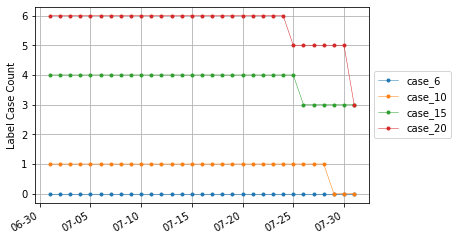

In [98]:
import matplotlib.dates as mdates







# df_ttl1.drop('level_0', axis=1, inplace=True)
# df_ttl1.reset_index(inplace=True)

# date_fmt = mdates.DateFormatter('%m-%d')
# df_ttl1['level_0'] = df_ttl1['level_0'].dt.strftime('%m-%d')
df_ttl1.set_index(df_ttl1['level_0'], inplace=True)
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
now = df_ttl1.iloc[0,0]
then = df_ttl1.iloc[-1,0]
days = mdates.drange(now,then,dt.timedelta(days=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

ax.plot(df_ttl1.loc[df_ttl1['level_1']==1, 'case_6'],
marker='.', linestyle='-', linewidth=0.5, label='case_6')
ax.plot(df_ttl1.loc[df_ttl1['level_1']==1, 'case_10'],
marker='.', linestyle='-', linewidth=0.5, label='case_10')
ax.plot(df_ttl1.loc[df_ttl1['level_1']==1, 'case_15'],
marker='.', linestyle='-', linewidth=0.5, label='case_15')
ax.plot(df_ttl1.loc[df_ttl1['level_1']==1, 'case_20'],
marker='.', linestyle='-', linewidth=0.5, label='case_20')
# ax.xaxis.set_major_formatter(date_fmt)
# round to nearest years.
# datemin = np.datetime64(df_ttl1['level_0'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlabel(df_ttl1['level_0'].unique().tolist())
# ax.set_xlim(df_ttl1.iloc[0,0], df_ttl1.iloc[-1,0])

# ax.set_xlim(df_ttl1.iloc[0,0], df_ttl1.iloc[-1,0])
legend_x = 1
legend_y = 0.5
plt.gcf().autofmt_xdate()
plt.legend(["case_6", "case_10", 'case_15','case_20'], loc='center left', bbox_to_anchor=(legend_x, legend_y))
ax.set_ylabel('Label Case Count')
ax.grid(True)
# ax.legend();

In [71]:
df_ttl1['level_0'].unique().tolist()

['07-01',
 '07-02',
 '07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09',
 '07-10',
 '07-11',
 '07-12',
 '07-13',
 '07-14',
 '07-15',
 '07-16',
 '07-17',
 '07-18',
 '07-19',
 '07-20',
 '07-21',
 '07-22',
 '07-23',
 '07-24',
 '07-25',
 '07-26',
 '07-27',
 '07-28',
 '07-29',
 '07-30',
 '07-31']

In [41]:
df_ttl.tail()

case_6  case_10  case_15  case_20
2020-08-01 1.0     0.0      0.0        3        3
2020-08-02 0.0    34.0     34.0       31       30
           1.0     0.0      0.0        3        4
2020-08-03 0.0    34.0     34.0       31       30
           1.0     0.0      0.0        3        4

In [19]:
df_6.shape

(20544, 6)

In [25]:
df_merge2.shape

(20544, 18)

In [15]:
# df_COVID1 = df_COVID.drop_duplicates(subset=['PRUID', 'HR_UID'], keep='last')
df_on = df_COVID.loc[df_COVID['PRUID']==str(24)]
df_COVID1 = df_on.groupby(['PRUID', 'HR_UID'])['cumulative_cases'].median().reset_index()
df_COVID1.nsmallest(5, 'cumulative_cases')

PRUID HR_UID  cumulative_cases
17    24   2418               6.0
9     24   2410               7.0
16    24   2417              15.0
0     24   2401              34.0
8     24   2409             106.0

In [21]:
df_COVID.loc[df_COVID['HR_UID']==str(2409)]

PRUID HR_UID health_region report_date  cases  cumulative_cases  deaths  \
17664    24   2409     côte-nord  2020-01-25      0                 0       0   
17665    24   2409     côte-nord  2020-01-26      0                 0       0   
17666    24   2409     côte-nord  2020-01-27      0                 0       0   
17667    24   2409     côte-nord  2020-01-28      0                 0       0   
17668    24   2409     côte-nord  2020-01-29      0                 0       0   
...     ...    ...           ...         ...    ...               ...     ...   
17843    24   2409     côte-nord  2020-07-22      1               126       0   
17844    24   2409     côte-nord  2020-07-23      0               126       0   
17845    24   2409     côte-nord  2020-07-24      0               126       0   
17846    24   2409     côte-nord  2020-07-25      0               126       0   
17847    24   2409     côte-nord  2020-07-26      0               126       0   

       cumulative_deaths  
17664                  0  
17665                  0  
17666                  0  
17667                  0  
17668                  0  
...                  ...  
17843                  0  
17844                  0  
17845                  0  
17846                  0  
17847                  0  

[184 rows x 8 columns]

In [ ]:
.ipynb_checkpoints/